Learning Objectives:  
    - Time series analysis and application of ML models  
    - Some CI/CD considerations  
    - Portfolio building  
  
Implementation 1: Machine learning models  
    - Ipynb or pdf should include:      
        - why that particular model was chosen   
        - Example of ML Models: SVM, Deep Learning, LSTM etc.  



In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import yfinance as yf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import math

# Getting the Data from Yahoo and Store into Pandas df

In [19]:
# Getting the data
time.sleep(1)
nvda = yf.Ticker("NVDA")
time.sleep(1)
# Get the 1 year historical data for NVDA
nvda_hist = nvda.history(period="5y")

# Make a pandas dataframe
nvda_df = pd.DataFrame(nvda_hist)

# Split the data into train and test
dataset_train, dataset_test = train_test_split(nvda_df, test_size=0.2, shuffle=False)
dataset_train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-10-23 00:00:00-04:00,48.924660,49.189346,48.434870,48.637711,42869600,0.0,0.0
2017-10-24 00:00:00-04:00,48.729239,49.164607,48.469500,49.147289,40724400,0.0,0.0
2017-10-25 00:00:00-04:00,48.751508,49.280878,47.289556,47.905506,82816000,0.0,0.0
2017-10-26 00:00:00-04:00,48.182551,48.523921,47.942603,48.407658,32274400,0.0,0.0
2017-10-27 00:00:00-04:00,48.929615,49.936406,48.669877,49.933933,57219200,0.0,0.0


Text(0, 0.5, 'Closing Price')

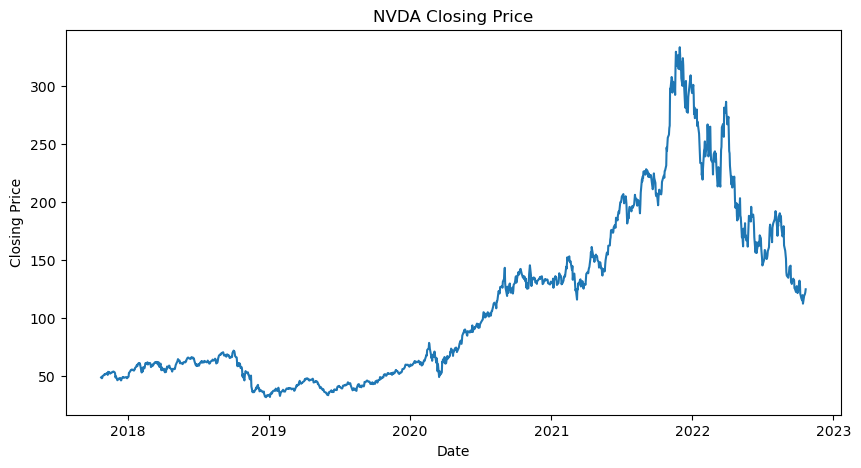

In [20]:
# Plot the closing price
plt.figure(figsize=(10,5))
plt.plot(nvda_df['Close'])
plt.title('NVDA Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Selecting the Close column to train our model

In [21]:
training_set = dataset_train.iloc[:,3:4].values
print(training_set)
print(training_set.shape)

[[ 48.63771057]
 [ 49.14728928]
 [ 47.90550613]
 ...
 [222.72145081]
 [220.85295105]
 [226.73825073]]
(1007, 1)


# Normializing the data

In [22]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)
print(training_set_scaled)

[[0.08689517]
 [0.08948579]
 [0.08317276]
 ...
 [0.97190895]
 [0.9624098 ]
 [0.99232971]]


# Creating X train and Y train data

In [23]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(947, 60)
(947,)


# Reshape the Data

In [24]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(947, 60, 1)


# Building the Model using LSTM

In [25]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

# Fitting the Model

In [26]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5


2022-10-22 12:37:16.205259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:16.763547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:17.026016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:17.237066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:17.489117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:17.904256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:18.319325: I tensorflow/core/grappler/optimizers/cust

30/30 [==============================] - 11s 196ms/step - loss: 0.0267
Epoch 2/5
30/30 [==============================] - 4s 119ms/step - loss: 0.0038
Epoch 3/5
30/30 [==============================] - 3s 114ms/step - loss: 0.0025
Epoch 4/5
30/30 [==============================] - 3s 115ms/step - loss: 0.0024
Epoch 5/5
30/30 [==============================] - 3s 114ms/step - loss: 0.0025


# Extracting the actual values from the data

In [27]:
actual_stock_price = dataset_test.iloc[:, 3:4].values

# Preparing the input for the model

In [28]:
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting the value for the stock price

In [29]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2022-10-22 12:37:39.575298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:39.712828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:39.877417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:40.050872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-22 12:37:40.224401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# Plotting the result

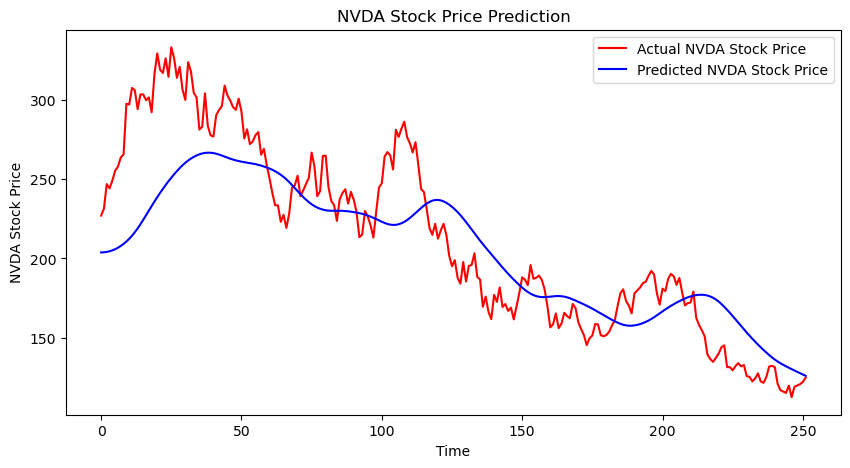

In [30]:
#Plot the results
plt.figure(figsize=(10,5))
plt.plot(actual_stock_price, color = 'red', label = 'Actual NVDA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()


# Evaluating the model

In [31]:
# Get the RMSE
rmse = math.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
print('The root mean squared error is {}.'.format(rmse))

The root mean squared error is 32.873913066476376.


# Predicting the future stock price of the next 12 days

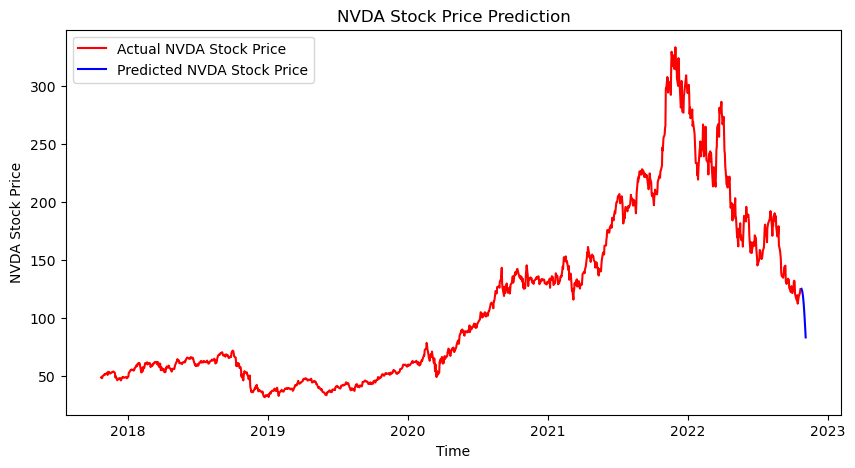

In [32]:
# Add another 15 empty days under nvda_df
whole_data = nvda_df['Close']
whole_data = whole_data.append(pd.Series([0]*12, index=pd.date_range(start='2022-10-24', periods=12, freq='D')))

# Predict for the next 12 days
inputs = whole_data[len(whole_data) - len(dataset_train) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price_last12 = predicted_stock_price[-12:]

# Plot the results original data and predicted data
plt.figure(figsize=(10,5))
plt.plot(nvda_df['Close'], color = 'red', label = 'Actual NVDA Stock Price')
plt.plot(whole_data.index[-12:], predicted_stock_price_last12, color = 'blue', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()




# Get a table for the predicted value

In [33]:
forcast = pd.DataFrame(predicted_stock_price_last12, index=whole_data.index[-12:], columns=['Close'])
# Make a empty dataframe
forecast_df = pd.DataFrame(columns=['Date'])
forecast_df['Date'] = pd.date_range(start='2022-10-24', end='2022-11-04')

# Add the forecasted values to the dataframe
forecast_df['Forecast'] = forcast.iloc[0]

for i in range(0, len(forecast_df)):
    forecast_df.iloc[i,1] = forcast.iloc[i]

# Make date as index
forecast_df = forecast_df.set_index('Date')
forecast_df
forecast_df.to_csv('YangJiAn_Impl_1.csv')
